In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

**unzip data file**

link data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [ ]:
!unzip "/content/drive/MyDrive/ColabNotebooks/Pneumonia Detect/archive.zip" -d "/content/drive/MyDrive/ColabNotebooks/Pneumonia Detect"

# **Importing the necessary libraries**

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import LSTM,GRU,SimpleRNN,Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,Reshape
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import cv2
import os
import numpy as np
import pandas as pd
import pickle

# **Data Visualization & Preprocessing**



In [1]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    images = []
    labels_list = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        img_each_label_count = 0
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                images.append(resized_arr)
                labels_list.append(class_num)
                img_each_label_count+=1
            except Exception as e:
                print(e)
        print("Number of", label, "images:", img_each_label_count)
    total_images = len(images)
    print("Total number of images:", total_images)
    print()
    return np.array(images), np.array(labels_list)

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

print("TRAIN SET:")
x_train, y_train = get_training_data('/content/drive/MyDrive/chest_xray/train')

print("VAL SET:")
x_val, y_val = get_training_data('/content/drive/MyDrive/chest_xray/val')

print("TEST SET:")
x_test, y_test = get_training_data('/content/drive/MyDrive/chest_xray/test')

<ipython-input-5-32fd7a8f4770>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=class_labels, palette=colors)


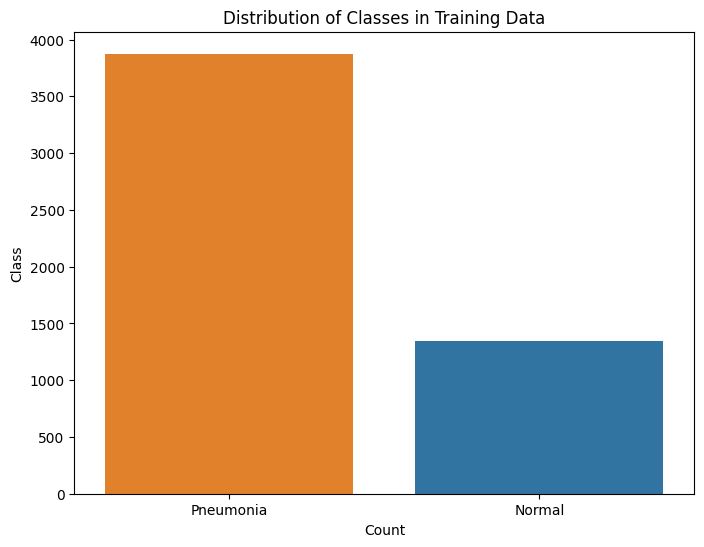

In [ ]:

# Convert labels to class names
class_names = ['Pneumonia', 'Normal']
class_labels = [class_names[label] for label in y_train]

# Set the color palette for the plot
colors = ['#ff7f0e', '#1f77b4']

# Create count plot with rotated x-axis labels and customized colors
plt.figure(figsize=(8, 6))
sns.countplot(x=class_labels, palette=colors)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()


In [ ]:
from imblearn.over_sampling import SMOTE

# Flatten hình ảnh
x_train_flattened = x_train.reshape(x_train.shape[0], -1)

# Khởi tạo mô hình SMOTE
smote = SMOTE(random_state=42)

# Áp dụng SMOTE cho dữ liệu huấn luyện và nhãn tương ứng
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flattened, y_train)



<ipython-input-7-82aa17249854>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=class_labels, palette=colors)


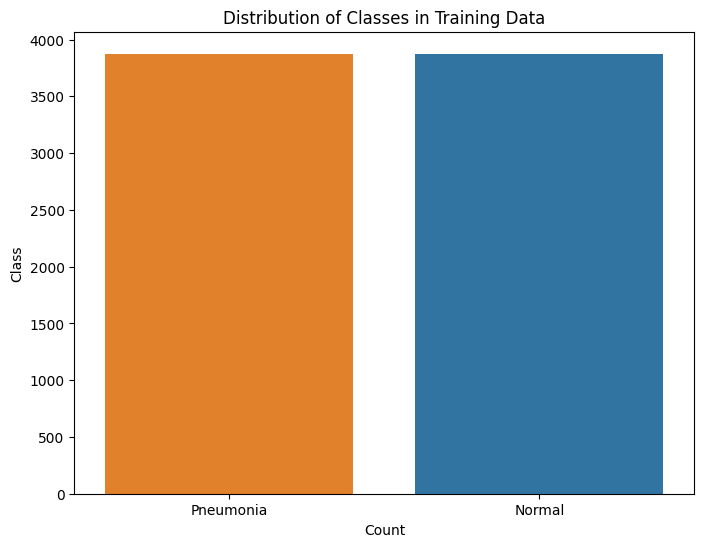

In [ ]:

# Convert labels to class names
class_names = ['Pneumonia', 'Normal']
class_labels = [class_names[label] for label in y_train_resampled]

# Set the color palette for the plot
colors = ['#ff7f0e', '#1f77b4']

# Create count plot with rotated x-axis labels and customized colors
plt.figure(figsize=(8, 6))
sns.countplot(x=class_labels, palette=colors)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()


The data seems imbalanced . To increase the no. of training

1.   Mục danh sách
2.   Mục danh sách

examples, we will use data augmentation

Previewing the images of both the classes

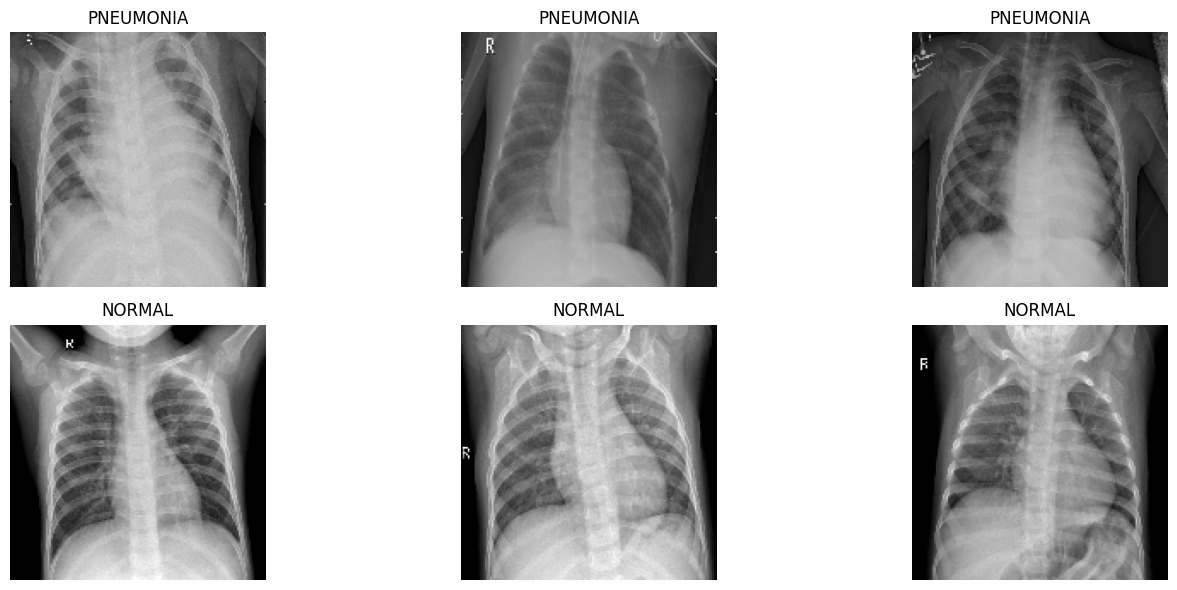

In [ ]:
# Define the number of images to display from each end
num_images_each_end = 3

# Create subplots
fig, axes = plt.subplots(2, num_images_each_end, figsize=(15, 6))

# Display the first 3 images
for i in range(num_images_each_end):
    axes[0, i].imshow(x_train[i], cmap='gray')
    axes[0, i].set_title(labels[y_train[i]])
    axes[0, i].axis('off')  # Hide axis labels

# Display the last 3 images
for i in range(num_images_each_end):
    axes[1, i].imshow(x_train[-num_images_each_end + i], cmap='gray')
    axes[1, i].set_title(labels[y_train[-num_images_each_end + i]])
    axes[1, i].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the data
x_train_resampled = np.array(x_train_resampled) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning
x_train_resampled = x_train_resampled.reshape(-1, img_size, img_size, 1)
y_train_resampled = np.array(y_train_resampled)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

**Data Augmentation**

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train_resampled)

For the data augmentation, i choosed to :

Randomly rotate some training images by 30 degrees
Randomly Zoom by 20% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

# **Train 3 model**


## Train model CNN
reference:
https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy/notebook

In [ ]:
model_CNN = Sequential()

model_CNN.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_CNN.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_CNN.add(Dropout(0.1))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_CNN.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_CNN.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_CNN.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_CNN.add(Flatten())

model_CNN.add(Dense(units = 128 , activation = 'relu'))
model_CNN.add(Dropout(0.2))

model_CNN.add(Dense(units = 1 , activation = 'sigmoid'))
model_CNN.summary()

model_CNN.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/model_and_history/best_model_CNN.h5', monitor='val_accuracy', save_best_only=True, mode='max')
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [learning_rate_reduction,checkpoint]

In [ ]:
history_CNN = model_CNN.fit(datagen.flow(x_train_resampled,y_train_resampled, batch_size = 32) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val) ,callbacks = callbacks)

Epoch 1/30
243/243 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8821

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 32s 95ms/step - loss: 0.3651 - accuracy: 0.8821 - val_loss: 16.9765 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
243/243 [==============================] - 23s 93ms/step - loss: 0.2258 - accuracy: 0.9203 - val_loss: 8.8161 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
243/243 [==============================] - 21s 86ms/step - loss: 0.1755 - accuracy: 0.9315 - val_loss: 1.4810 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/30
243/243 [==============================] - 22s 92ms/step - loss: 0.1584 - accuracy: 0.9430 - val_loss: 0.8691 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
243/243 [==============================] - 27s 109ms/step - loss: 0.1333 - accuracy: 0.9535 - val_loss: 7.7389 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/30
243/243 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9563
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
243/243 [==============================] - 20s 83ms/

In [ ]:
model_CNN.save('/content/drive/MyDrive/model_and_history/last_model_CNN.h5')
with open('/content/drive/MyDrive/model_and_history/history_CNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN.history, file_pi)

##Train model CNN-LSTM

In [ ]:
# Define the CNN-LSTM model
model_CNN_LSTM = Sequential()

# Add CNN layers
model_CNN_LSTM.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model_CNN_LSTM.add(BatchNormalization())
model_CNN_LSTM.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_LSTM.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_LSTM.add(Dropout(0.1))
model_CNN_LSTM.add(BatchNormalization())
model_CNN_LSTM.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_LSTM.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_LSTM.add(BatchNormalization())
model_CNN_LSTM.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_LSTM.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_LSTM.add(Dropout(0.2))
model_CNN_LSTM.add(BatchNormalization())
model_CNN_LSTM.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_LSTM.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_LSTM.add(Dropout(0.2))
model_CNN_LSTM.add(BatchNormalization())
model_CNN_LSTM.add(MaxPool2D((2, 2), strides=2, padding='same'))

# Reshape output from CNN layers into sequences
model_CNN_LSTM.add(Reshape((5, 5 * 256)))  # Assuming output shape from CNN layers is (5, 5, 256)

# Add LSTM layers
model_CNN_LSTM.add(LSTM(units=128, return_sequences=True))
model_CNN_LSTM.add(LSTM(units=64, return_sequences=False))  # Added another LSTM layer

# Flatten output from LSTM layer
model_CNN_LSTM.add(Flatten())

# Add dense layers
model_CNN_LSTM.add(Dense(units=128, activation='relu'))
model_CNN_LSTM.add(Dropout(0.2))
model_CNN_LSTM.add(Dense(units=1, activation='sigmoid'))

model_CNN_LSTM.summary()

model_CNN_LSTM.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 75, 75, 64)       

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/model_and_history/best_model_CNN_LSTM.h5', monitor='val_accuracy', save_best_only=True, mode='max')
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [learning_rate_reduction,checkpoint]

In [ ]:
history_CNN_LSTM = model_CNN_LSTM.fit(datagen.flow(x_train_resampled,y_train_resampled, batch_size = 32) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val) ,callbacks = callbacks)

Epoch 1/30
243/243 [==============================] - 30s 101ms/step - loss: 0.2659 - accuracy: 0.8885 - val_loss: 2.3895 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
243/243 [==============================] - 21s 85ms/step - loss: 0.1831 - accuracy: 0.9283 - val_loss: 2.7599 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
243/243 [==============================] - 23s 92ms/step - loss: 0.1507 - accuracy: 0.9415 - val_loss: 0.7439 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/30
243/243 [==============================] - 22s 90ms/step - loss: 0.1315 - accuracy: 0.9495 - val_loss: 1.7729 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/30
243/243 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9547
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
243/243 [==============================] - 23s 92ms/step - loss: 0.1195 - accuracy: 0.9547 - val_loss: 2.3303 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/30
243/243 [==============================] -

In [ ]:
model_CNN_LSTM.save('/content/drive/MyDrive/model_and_history/last_model_CNN_LSTM.h5')
with open('/content/drive/MyDrive/model_and_history/history_CNN_LSTM.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN_LSTM.history, file_pi)

##Train model CNN-RNN

In [ ]:
# Define the CNN-RNN model
model_CNN_RNN = Sequential()

# Add CNN layers
model_CNN_RNN.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_RNN.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_RNN.add(Dropout(0.1))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_RNN.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_RNN.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_RNN.add(Dropout(0.2))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPool2D((2, 2), strides=2, padding='same'))

model_CNN_RNN.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model_CNN_RNN.add(Dropout(0.2))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPool2D((2, 2), strides=2, padding='same'))

# Reshape output from CNN layers into sequences
model_CNN_RNN.add(Reshape((5, 5 * 256)))  # Assuming output shape from CNN layers is (5, 5, 256)

# Add RNN layers
model_CNN_RNN.add(SimpleRNN(units=128, return_sequences=True))
model_CNN_RNN.add(SimpleRNN(units=64, return_sequences=False))  # Added another RNN layer

# Flatten output from RNN layer
model_CNN_RNN.add(Flatten())

# Add dense layers
model_CNN_RNN.add(Dense(units=128, activation='relu'))
model_CNN_RNN.add(Dropout(0.2))
model_CNN_RNN.add(Dense(units=1, activation='sigmoid'))

model_CNN_RNN.summary()

model_CNN_RNN.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_10 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_11 (Ba  (None, 75, 75, 64)       

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/model_and_history/best_model_CNN_RNN.h5', monitor='val_accuracy', save_best_only=True, mode='max')
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [learning_rate_reduction,checkpoint]

In [ ]:
history_CNN_RNN = model_CNN_RNN.fit(datagen.flow(x_train_resampled,y_train_resampled, batch_size = 32) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val) ,callbacks = callbacks)

Epoch 1/30
243/243 [==============================] - 28s 94ms/step - loss: 0.2828 - accuracy: 0.8799 - val_loss: 2.2021 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
243/243 [==============================] - 23s 96ms/step - loss: 0.1942 - accuracy: 0.9284 - val_loss: 1.9032 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
243/243 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9299
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
243/243 [==============================] - 24s 98ms/step - loss: 0.1761 - accuracy: 0.9299 - val_loss: 2.0538 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
243/243 [==============================] - 23s 95ms/step - loss: 0.1358 - accuracy: 0.9512 - val_loss: 1.9181 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/30
243/243 [==============================] - 23s 93ms/step - loss: 0.1198 - accuracy: 0.9572 - val_loss: 2.2693 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/30
243/243 [==========================

In [ ]:
model_CNN_RNN.save('/content/drive/MyDrive/model_and_history/last_model_CNN_RNN.h5')
with open('/content/drive/MyDrive/model_and_history/history_CNN_RNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN_RNN.history, file_pi)

# **Compare 3 model**

In [6]:
from keras.models import load_model

best_model_CNN = load_model("/content/drive/MyDrive/model_and_history/best_model_CNN.h5")
best_model_CNN_LSTM = load_model("/content/drive/MyDrive/model_and_history/best_model_CNN_LSTM.h5")
best_model_CNN_RNN = load_model("/content/drive/MyDrive/model_and_history/best_model_CNN_RNN.h5")

In [7]:
history_path_CNN = "/content/drive/MyDrive/model_and_history/history_CNN.pkl"
history_path_CNN_LSTM = "/content/drive/MyDrive/model_and_history/history_CNN_LSTM.pkl"
history_path_CNN_RNN = "/content/drive/MyDrive/model_and_history/history_CNN_RNN.pkl"

with open(history_path_CNN, 'rb') as file:
    history_CNN = pickle.load(file)
with open(history_path_CNN_LSTM, 'rb') as file:
    history_CNN_LSTM = pickle.load(file)
with open(history_path_CNN_RNN, 'rb') as file:
    history_CNN_RNN = pickle.load(file)

## Compare loss and accuracy on test

In [ ]:
print("Loss of the CNN model is - ", best_model_CNN.evaluate(x_test, y_test)[0])
print("Accuracy of the CNN model is - ", best_model_CNN.evaluate(x_test, y_test)[1] * 100, "%")
print("--------------------------------------------------------------------------------")
print()

print("Loss of the CNN-LSTM model is - ", best_model_CNN_LSTM.evaluate(x_test, y_test)[0])
print("Accuracy of the CNN-LSTM model is - ", best_model_CNN_LSTM.evaluate(x_test, y_test)[1] * 100, "%")
print("--------------------------------------------------------------------------------")
print()

print("Loss of the CNN-RNN model is - ", best_model_CNN_RNN.evaluate(x_test, y_test)[0])
print("Accuracy of the CNN-RNN model is - ", best_model_CNN_RNN.evaluate(x_test, y_test)[1] * 100, "%")


20/20 [==============================] - 1s 13ms/step - loss: 0.3777 - accuracy: 0.8446
Loss of the CNN model is -  0.3777358829975128
20/20 [==============================] - 0s 11ms/step - loss: 0.3777 - accuracy: 0.8446
Accuracy of the CNN model is -  84.45512652397156 %
--------------------------------------------------------------------------------

20/20 [==============================] - 1s 11ms/step - loss: 0.7954 - accuracy: 0.5433
Loss of the CNN-LSTM model is -  0.7953805923461914
20/20 [==============================] - 0s 12ms/step - loss: 0.7954 - accuracy: 0.5433
Accuracy of the CNN-LSTM model is -  54.326921701431274 %
--------------------------------------------------------------------------------

20/20 [==============================] - 1s 11ms/step - loss: 0.3805 - accuracy: 0.8141
Loss of the CNN-RNN model is -  0.3804676830768585
20/20 [==============================] - 0s 11ms/step - loss: 0.3805 - accuracy: 0.8141
Accuracy of the CNN-RNN model is -  81.410259008

## Compare loss and accuracy history

In [ ]:
history_CNN.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

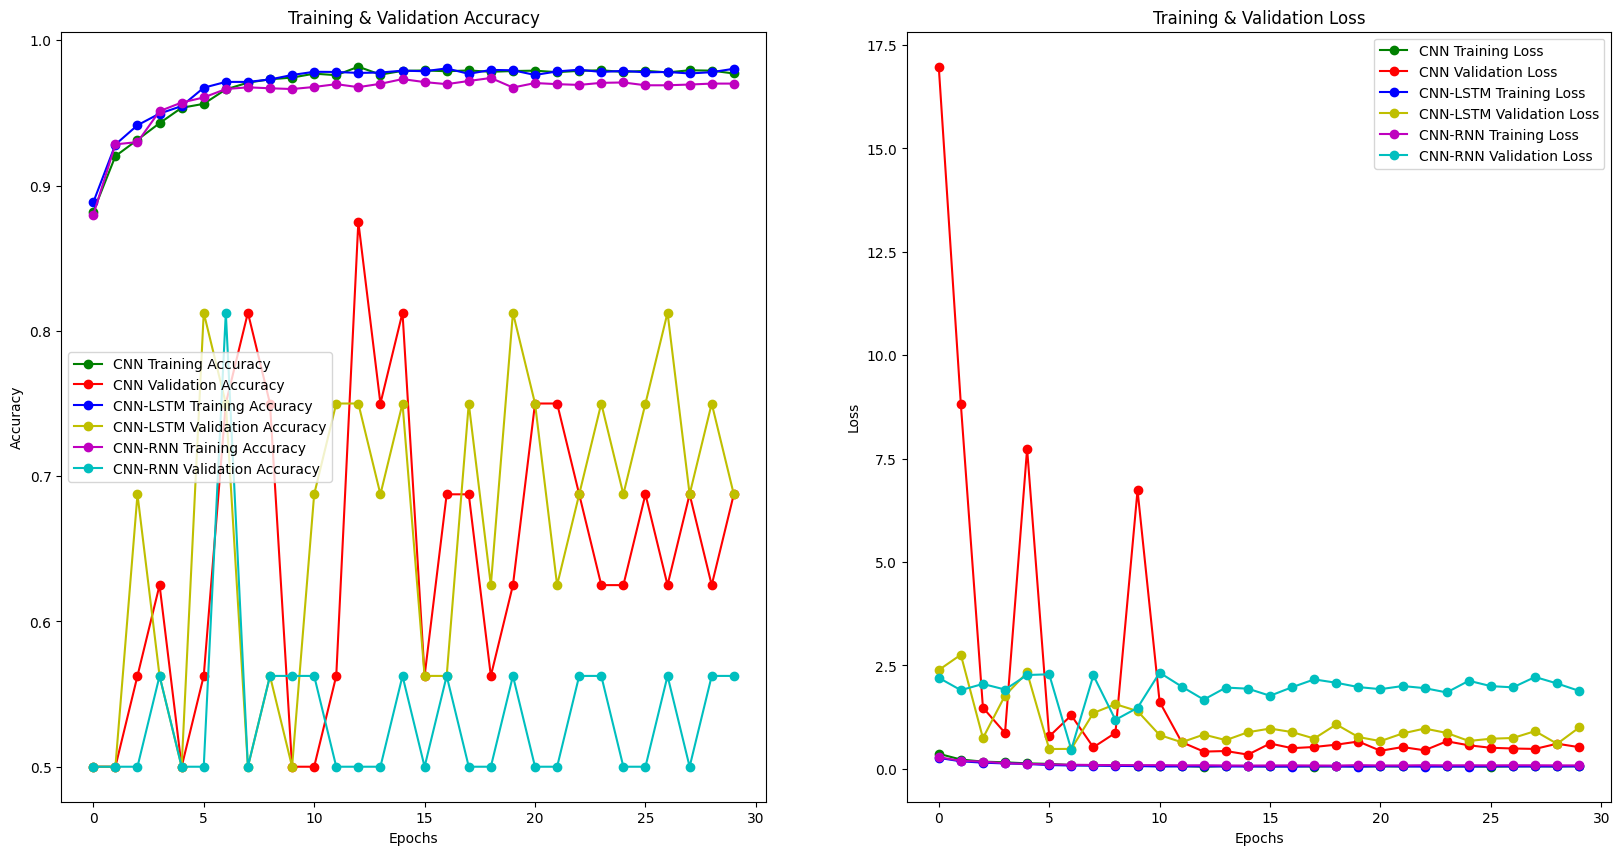

In [ ]:
# Extract the number of epochs used for each model
epochs_CNN = len(history_CNN['accuracy'])
epochs_CNN_LSTM = len(history_CNN_LSTM['accuracy'])
epochs_CNN_RNN = len(history_CNN_RNN['accuracy'])

# Create a list of epochs for each model
epochs = [i for i in range(max(epochs_CNN, epochs_CNN_LSTM, epochs_CNN_RNN))]

# Plotting
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

# Plot accuracy
ax[0].plot(range(epochs_CNN), history_CNN['accuracy'], 'go-', label='CNN Training Accuracy')
ax[0].plot(range(epochs_CNN), history_CNN['val_accuracy'], 'ro-', label='CNN Validation Accuracy')
ax[0].plot(range(epochs_CNN_LSTM), history_CNN_LSTM['accuracy'], 'bo-', label='CNN-LSTM Training Accuracy')
ax[0].plot(range(epochs_CNN_LSTM), history_CNN_LSTM['val_accuracy'], 'yo-', label='CNN-LSTM Validation Accuracy')
ax[0].plot(range(epochs_CNN_RNN), history_CNN_RNN['accuracy'], 'mo-', label='CNN-RNN Training Accuracy')
ax[0].plot(range(epochs_CNN_RNN), history_CNN_RNN['val_accuracy'], 'co-', label='CNN-RNN Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plot loss
ax[1].plot(range(epochs_CNN), history_CNN['loss'], 'g-o', label='CNN Training Loss')
ax[1].plot(range(epochs_CNN), history_CNN['val_loss'], 'r-o', label='CNN Validation Loss')
ax[1].plot(range(epochs_CNN_LSTM), history_CNN_LSTM['loss'], 'b-o', label='CNN-LSTM Training Loss')
ax[1].plot(range(epochs_CNN_LSTM), history_CNN_LSTM['val_loss'], 'y-o', label='CNN-LSTM Validation Loss')
ax[1].plot(range(epochs_CNN_RNN), history_CNN_RNN['loss'], 'm-o', label='CNN-RNN Training Loss')
ax[1].plot(range(epochs_CNN_RNN), history_CNN_RNN['val_loss'], 'c-o', label='CNN-RNN Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [ ]:
# Predictions for CNN Model
predictions_CNN = model_CNN.predict(x_test)
predictions_CNN = (predictions_CNN > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary predictions

# Predictions for CNN-LSTM Model
predictions_CNN_LSTM = model_CNN_LSTM.predict(x_test)
predictions_CNN_LSTM = (predictions_CNN_LSTM > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary predictions

# Predictions for CNN-RNN Model
predictions_CNN_RNN = model_CNN_RNN.predict(x_test)
predictions_CNN_RNN = (predictions_CNN_RNN > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary predictions

# Print first 15 predictions for each model
print("Predictions for CNN model:", predictions_CNN[:50])
print("Predictions for CNN-LSTM model:", predictions_CNN_LSTM[:50])
print("Predictions for CNN-RNN model:", predictions_CNN_RNN[:50])
print()
print("-------------------------------------------------------")
print("True labels:",y_test[:50])


20/20 [==============================] - 0s 9ms/step
Predictions for CNN model: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0 1]
Predictions for CNN-LSTM model: [0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0]
Predictions for CNN-RNN model: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1]

-------------------------------------------------------
True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(classification_report(y_test, predictions_CNN, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
print(classification_report(y_test, predictions_CNN_LSTM, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
print(classification_report(y_test, predictions_CNN_RNN, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.89      0.92       390
   Normal (Class 1)       0.83      0.91      0.87       234

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.89       624
       weighted avg       0.90      0.90      0.90       624

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.82      0.88       390
   Normal (Class 1)       0.75      0.93      0.83       234

           accuracy                           0.86       624
          macro avg       0.85      0.87      0.86       624
       weighted avg       0.88      0.86      0.86       624

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.87      0.97      0.92       390
   Normal (Class 1)       0.94      0.76      0.84       234

           accuracy                           0.89       624
          macro 

In [ ]:
cm_CNN = confusion_matrix(y_test, predictions_CNN)

cm_CNN_LSTM = confusion_matrix(y_test, predictions_CNN_LSTM)

cm_CNN_RNN = confusion_matrix(y_test, predictions_CNN_RNN)

print("Confusion matrix for CNN model:")
print(cm_CNN)

print("Confusion matrix for CNN-LSTM model:")
print(cm_CNN_LSTM)

print("Confusion matrix for CNN-RNN model:")
print(cm_CNN_RNN)

Confusion matrix for CNN model:
[[348  42]
 [ 22 212]]
Confusion matrix for CNN-LSTM model:
[[319  71]
 [ 16 218]]
Confusion matrix for CNN-RNN model:
[[378  12]
 [ 55 179]]


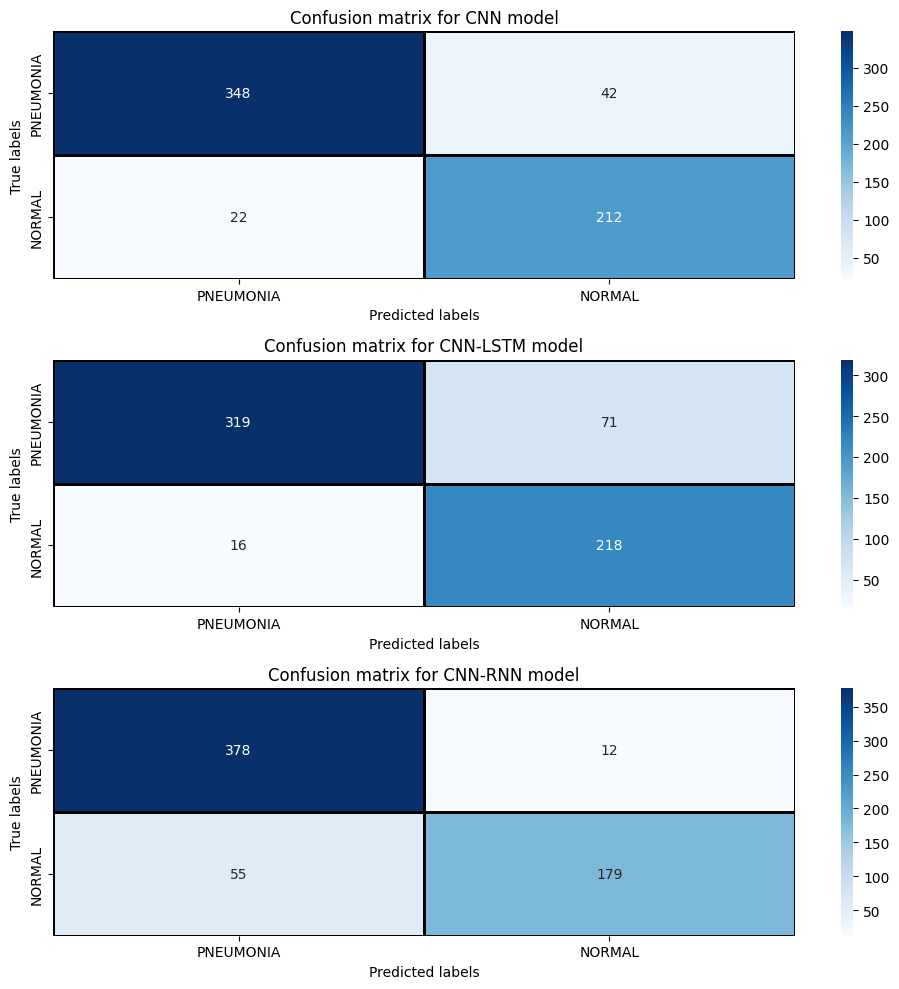

In [ ]:
cm_CNN = pd.DataFrame(cm_CNN, index=['0', '1'], columns=['0', '1'])
cm_CNN_LSTM = pd.DataFrame(cm_CNN_LSTM, index=['0', '1'], columns=['0', '1'])
cm_CNN_RNN = pd.DataFrame(cm_CNN_RNN, index=['0', '1'], columns=['0', '1'])


plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
sns.heatmap(cm_CNN, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix for CNN model')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


plt.subplot(3, 1, 2)
sns.heatmap(cm_CNN_LSTM, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix for CNN-LSTM model')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


plt.subplot(3, 1, 3)
sns.heatmap(cm_CNN_RNN, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix for CNN-RNN model')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.tight_layout()
plt.show()

20/20 [==============================] - 12s 556ms/step


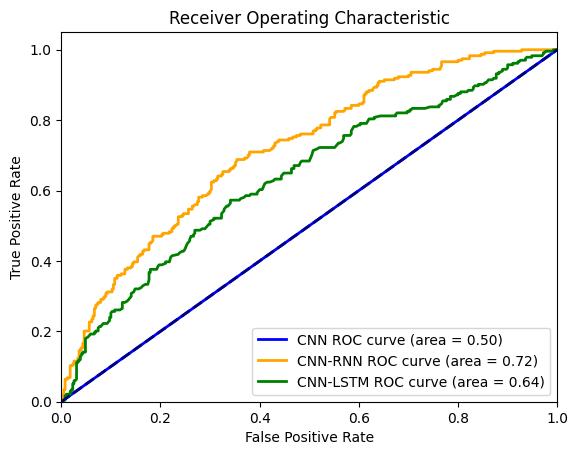

In [12]:
# Dự đoán trên tập test
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.models import load_model

cnn_pred = best_model_CNN.predict(x_test).ravel()
cnn_rnn_pred = best_model_CNN_RNN.predict(x_test).ravel()
cnn_lstm_pred = best_model_CNN_LSTM.predict(x_test).ravel()

# Tính toán ROC và AUC
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_pred)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_cnn_rnn, tpr_cnn_rnn, _ = roc_curve(y_test, cnn_rnn_pred)
roc_auc_cnn_rnn = auc(fpr_cnn_rnn, tpr_cnn_rnn)

fpr_cnn_lstm, tpr_cnn_lstm, _ = roc_curve(y_test, cnn_lstm_pred)
roc_auc_cnn_lstm = auc(fpr_cnn_lstm, tpr_cnn_lstm)

# Vẽ biểu đồ ROC
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label='CNN ROC curve (area = %0.2f)' % roc_auc_cnn)
plt.plot(fpr_cnn_rnn, tpr_cnn_rnn, color='orange', lw=2, label='CNN-RNN ROC curve (area = %0.2f)' % roc_auc_cnn_rnn)
plt.plot(fpr_cnn_lstm, tpr_cnn_lstm, color='green', lw=2, label='CNN-LSTM ROC curve (area = %0.2f)' % roc_auc_cnn_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##Some of the Correctly and Incorrectly Predicted Classes of CNN model

In [ ]:
correct_CNN = np.nonzero(predictions_CNN == y_test)[0]

incorrect_CNN = np.nonzero(predictions_CNN != y_test)[0]

<ipython-input-31-3b29e856129f>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


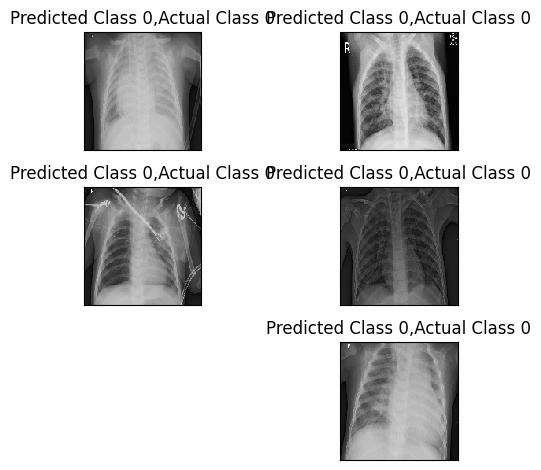

In [ ]:
i = 0
for c in correct_CNN[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions_CNN[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-32-160ff3399f7a>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


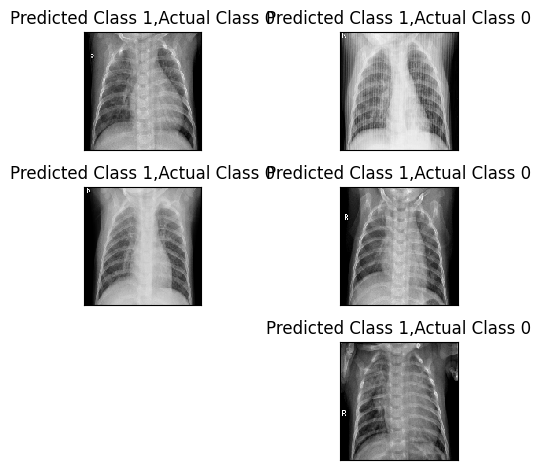

In [ ]:
i = 0
for c in incorrect_CNN[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions_CNN[c], y_test[c]))
    plt.tight_layout()
    i += 1

##Some of the Correctly and Incorrectly Predicted Classes of CNN_LSTM model

In [ ]:
correct_CNN_LSTM = np.nonzero(predictions_CNN_LSTM == y_test)[0]

incorrect_CNN_LSTM = np.nonzero(predictions_CNN_LSTM != y_test)[0]

<ipython-input-34-7af74e783192>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


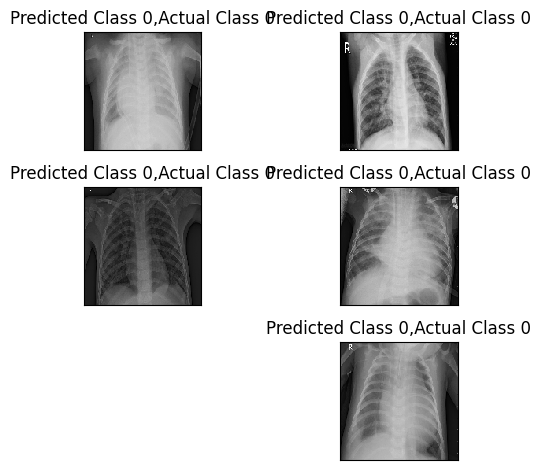

In [ ]:
i = 0
for c in correct_CNN_LSTM[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions_CNN_LSTM[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-35-5dfbecfa8ba7>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


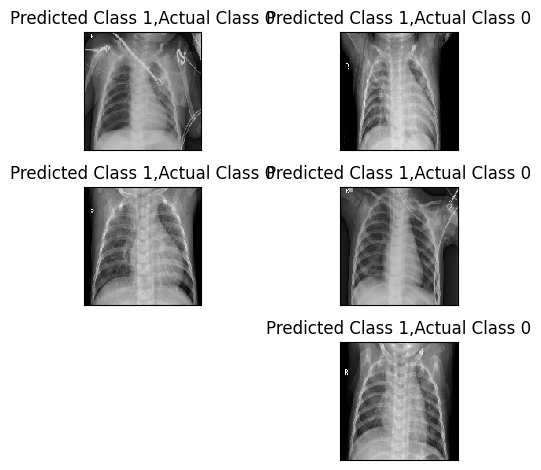

In [ ]:
i = 0
for c in incorrect_CNN_LSTM[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions_CNN_LSTM[c], y_test[c]))
    plt.tight_layout()
    i += 1

##Some of the Correctly and Incorrectly Predicted Classes of CNN_RNN model

In [ ]:
correct_CNN_RNN = np.nonzero(predictions_CNN_RNN == y_test)[0]

incorrect_CNN_RNN = np.nonzero(predictions_CNN_RNN != y_test)[0]

<ipython-input-37-fd0ffe2f979c>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


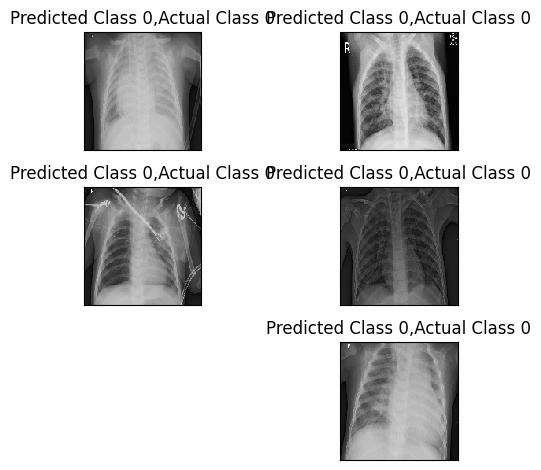

In [ ]:
i = 0
for c in correct_CNN_RNN[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions_CNN_RNN[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-38-2c8cff4aff49>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


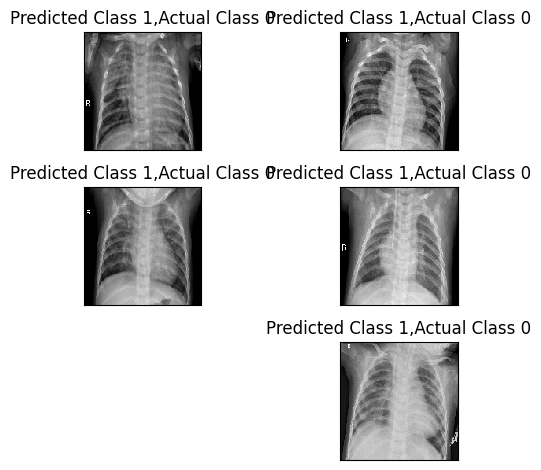

In [ ]:
i = 0
for c in incorrect_CNN_RNN[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions_CNN_RNN[c], y_test[c]))
    plt.tight_layout()
    i += 1